# Nonlinear computations in spiking neural networks through multiplicative synapses - Supplementary Figures
Michele Nardin, James W Phillips, William F Podlaski, Sander W Keemink

### Imports

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import find_peaks
import scipy.stats as stat

### Plot settings

In [2]:
matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams['figure.dpi'] = 90

## Supplementary Figure 2

Lorentz system, simulate real solution numerically with great precision and analyse consecutive peaks

In [4]:
rho=28;sigma=10;beta=8/3
def f(X, t):
  x, y, z = X
  return sigma * (y - x), x * (rho - z) - y, x * y - beta * z

# initial condition
x0 = np.array([-11.40057002, -14.01987468,  27.49928125])
# time
dt = 0.0001
t = np.arange(0.0, 100, dt)
# simulation
lorenz = odeint(f, x0, t)
# long simulation for peak analysis
lorenz_long = odeint(f, x0, np.arange(0.0, 100*100, dt))
xl=lorenz_long.T
# peaks analysis
peaks = find_peaks(xl[2, :], width=210)
# consecutive peaks
zl = xl[2, peaks[0]]

### Robustness of Lorenz mSCN

Code for Supp. Fig 2 panels A, B and D

In [44]:
# common parameters
Time = 15 # total time
Nt=int(Time/dt)
N = 100 # neurons

# dimensionality of input
K = 3

# initialize (full) decoding matrix
D=np.random.randn(K,N) # N x K
# last 6 neurons: make sure that the cube is covered
# this is a non-necessary precaution -> comment out the next two lines if need be
D[0,N-6] = D[1,N-2] = D[2,N-4] = 1
D[0,N-1] = D[1,N-3] = D[2,N-5] = -1
D = D / np.sqrt(np.diag(D.T@D)) # normalize
D = D/10
# threshold
T = np.diag(D.T@D)/2

Write Lorenz system as a Kronecker product:
Linear part ($Y' = AY$)

In [45]:
A = np.array([[-sigma,sigma,0],[rho,-1,0],[0,0,-beta]])

Nonlinear part ($Y' = B Y\otimes Y$) where $\otimes$ is Kroenecker product

In [ ]:
B = np.array([[0]*9,
              [0,0,-1]+[0]*6,
              [0,1]+[0]*7])

Initialize Voltage, spikes, rate

In [46]:
# 
V = np.zeros([N,Nt+1])
s = np.zeros([N,Nt+1])
r = np.zeros([N,Nt+1])

# Set initial conditions
r[:,0] = np.array(np.linalg.pinv(D)@x0) # pseudo-inverse
V[:,0] = 0.9*T
tau=0.5

# Network connections:
# - fast
O_f = D.T @ D
# - slow
O_s = D.T @ (tau*np.identity(K) + A) @ D
# - nonlinear
O_nl =D.T @ B @ np.kron(D,D)

run simulation and kill 10 neurons every second

In [47]:
# actual simulation: simple forward Euler
np.random.seed(0)
Tk = np.array(T).copy()
for t in range(Nt):
    ## do the killing
    if t>0 and np.mod(t,int(1/dt)) == 0  and t < 1/dt * 9 + 1:
        # simply set the threshold to astronomic value
        Tk[:10*int(t * dt)] = 1e06
    V[:,t+1] = V[:,t] + dt*(-tau*V[:,t] - O_f@s[:,t] + O_s @ r[:,t] + O_nl @ np.kron(r[:,t],r[:,t]))
    # check if there are neurons whose voltage is above threshold
    above = np.where(V[:,t+1] > Tk)[0]
    # introduce a control to let only one neuron fire
    if len(above):
        s[np.argmax(V[:,t+1] - Tk),t+1] = 1/dt
    # update rate
    r[:,t+1] = r[:,t] + dt*(s[:,t+1] - tau*r[:,t])

In [48]:
# "Decode" - i.e. multiply rate with decoding matrix D
xn = D@r

In [49]:
# peak analysis
peaks = find_peaks(xn[2, :], width=210)
zn = xn[2, peaks[0]]

run simulation using 10 neurons only

In [51]:
# Initialize Voltage, spikes, rate
Vr = np.zeros([10,10*Nt+1])
sr = np.zeros([10,10*Nt+1])
rr = np.zeros([10,10*Nt+1])

# Set initial conditions
D10 = D[:,-10:]
tr = T[-10:]
rr[:,0] = np.array(np.linalg.pinv(D10)@x0) # pseudo-inverse
Vr[:,0] = 0.9*tr
tau=0.5
# Network connections:
# - fast
O_f = D10.T @ D10
# - slow
O_s = D10.T @ (tau*np.identity(K) + A) @ D10
# - nonlinear
O_nl =D10.T @ B @ np.kron(D10,D10)

In [52]:
# actual simulation: simple forward Euler
np.random.seed(0)
for t in range(Nt*10):
    Vr[:,t+1] = Vr[:,t] + dt*(-tau*Vr[:,t] - O_f@sr[:,t] + O_s @ rr[:,t] + O_nl @ np.kron(rr[:,t],rr[:,t]))
    
    # check if there are neurons whose voltage is above threshold
    above = np.where(Vr[:,t+1] > tr)[0]
    
    # let only one neuron fire
    if len(above):
        sr[np.argmax(Vr[:,t+1] - tr),t+1] = 1/dt
    
    # update rate
    rr[:,t+1] = rr[:,t] + dt*(sr[:,t+1] - tau*rr[:,t])

In [53]:
# Decode - D@r
xnr = D10@rr

In [54]:
# peak analysis
peaks = find_peaks(xnr[2, :], width=210)
znr = xnr[2, peaks[0]]

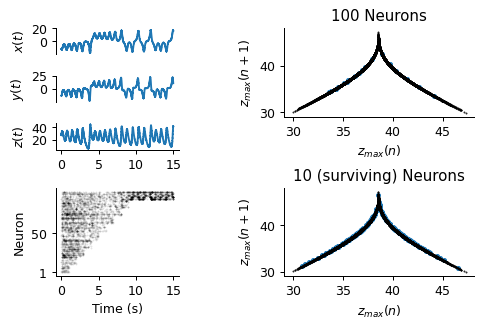

In [55]:
# plotting
plt.figure(figsize=(6,6))
labs=['x','y','z']
yts = [[0,20],[0,25],[20,40]]

# plot the three signal dimensions outputted by the network
for i in range(3):
    ax = plt.subplot(9,3,1+3*i)
    [ax.spines[s].set_visible(False) for s in ['right','top','bottom']]
    plt.plot(xn[i])
    plt.ylabel('$'+labs[i]+'(t)$')
    plt.xticks([])
    plt.yticks(yts[i],yts[i])
ax.spines['bottom'].set_visible(True)
plt.xticks([0,50000,100000,150000],[0,5,10,15])

# raster plot - show the neurons dying
ax = plt.subplot(3,3,4)
[ax.spines[s].set_visible(False) for s in ['right','top']]
a=np.where(s[:,(np.arange(int(len(s[0])/10))*10).astype(int)])
plt.scatter(a[1],a[0],marker='.',s=1,color='k',alpha=0.1)
plt.xticks([0,5000,10000,15000],[0,5,10,15])
plt.yticks([0,48],[1,50])
plt.xlabel('Time (s)')
plt.ylabel('Neuron')

# peak analysis with 100 neurons
ax = plt.subplot(3,2,2)
plt.scatter(zn[:-1], zn[1:],marker='.',rasterized=True)
plt.scatter(zl[:-1], zl[1:],marker='.',s=1,color='k',rasterized=True)
[ax.spines[s].set_visible(False) for s in ['right','top']]
plt.xlabel('$z_{max}(n)$')
plt.ylabel('$z_{max}(n+1)$')
plt.title('100 Neurons')

# peak analysis for the remaining 10 neurons
ax = plt.subplot(3,2,4)
plt.scatter(znr[:-1], znr[1:],marker='.',rasterized=True)
plt.scatter(zl[:-1], zl[1:],marker='.',s=1,color='k',rasterized=True)
[ax.spines[s].set_visible(False) for s in ['right','top']]
plt.xlabel('$z_{max}(n)$')
plt.ylabel('$z_{max}(n+1)$')
plt.title('10 (surviving) Neurons')
plt.subplots_adjust(hspace=0.8)

### Robustness and error with different decoder densities

Code for supp. fig. 2 panel C

Average squared error as a function of the proportion of neurons lost (out of 100 total)
for different choices of decoder density. 

The error was computed by measuring the average squared distance of the network readout
from the real solution of the Lorenz dynamical system (computed using a Runge-Kutta
4th order algorithm). 

In [17]:
Time = 0.1 # total time - simulate only a tiny part, 
# here we are sure that the solution is the same as the real one in any "good" case

dt = 0.0001 # time step
Nt=int(Time/dt)
tau=0.75
# dimensionality
K = 3

In [18]:
# standard Lorentz simulation
rho=28;sigma=10;beta=8/3
def f(X, t):
  x, y, z = X
  return sigma * (y - x), x * (rho - z) - y, x * y - beta * z

x0 = np.array([-11.40057002, -14.01987468,  27.49928125])
t = np.arange(0.0, Time, dt)

# lorenz = odeint(f, x0, t)
# use Euler
lorenz = np.zeros([len(t),3])
lorenz[0] = x0
for it in range(1,len(t)):
    lorenz[it] = lorenz[it-1] + dt*np.array(f(lorenz[it - 1],0))

# the output will be compared to this one
x=lorenz.T

In [19]:
# prepare matrices for the computation
# We will need to write it as a Kronecker product:
# - Linear part (Y' = AY)
A = np.array([[-sigma,sigma,0],[rho,-1,0],[0,0,-beta]])
# - Nonlinear part (Y' = A Y +  B Y(x)Y) where (x) is Kroenecker product
B = np.array([[0]*9,
              [0,0,-1]+[0]*6,
              [0,1]+[0]*7])

In [44]:
# save the mean squared errors for 100, 90, 80,...,10 neurons

# initial number of neurons
N = 100
steps=10

# Different choices of p: 0.25,0.5,0.75,1
ps = [0.25,0.5,0.75, 1]
# - 1000 simulations for each combination N,p
Nrepeats = 1000

errors = np.zeros([int(N/steps),len(ps),Nrepeats])

for ip, p in enumerate(ps):
    print('*',end='')

    for ish, sh in enumerate(range(Nrepeats)):
        
        D=np.random.randn(K,N) # N x K random decoding matrix
        D[np.random.rand(K,N) > p] = 0 # enforce sparsity

        # renormalize
        D = D / np.sqrt(np.diag(D.T@D)) # normalization
        D = D/10
        D[np.isnan(D)]=0 # in case there are divisions by zero (can happend if one row=0 everywhere)

        # threshold
        T = np.diag(D.T@D)/2

        for iNtk, Ntk in enumerate(np.arange(10)*10): # neurons to kill
                      
            # Initialize Voltage, spikes, rate
            V = np.zeros([N,Nt+1])
            s = np.zeros([N,Nt+1])
            r = np.zeros([N,Nt+1])

            # Set initial conditions
            r[:,0] = np.array(np.linalg.pinv(D)@x0) # pseudo-inverse
            V[:,0] = 0.9*T
            
            # "kill" the first Ntk neurons by simply setting their threshold to a very high value
            # it's as if the network was fine till just before the beginning, and then Ntk neurons die out
            # we start always from the same starting point so to have a fair comparison
            
            T[:Ntk] = 10000
            V[:Ntk,0] = 0

            # Network connections:
            # - fast
            O_f = D.T @ D
            # - slow
            O_s = D.T @ (tau*np.identity(K) + A) @ D
            # - nonlinear
            O_nl =D.T @ B @ np.kron(D,D)

            # network simulation: simple forward Euler
            for t in range(Nt):
                V[:,t+1] = V[:,t] + dt*(-tau*V[:,t] 
                                        - O_f@s[:,t] 
                                        + O_s @ r[:,t] 
                                        + O_nl @ np.kron(r[:,t],r[:,t]))

                # check if there are neurons whose voltage is above threshold
                above = np.where(V[:,t+1] > T)[0]

                # introduce a control to let only one neuron fire
                if len(above):
                    s[Ntk + np.argmax(V[Ntk:,t+1]),t+1] = 1/dt
                # update rate
                r[:,t+1] = r[:,t] + dt*(s[:,t+1] - tau*r[:,t])

            # measure squared error
            xn = D@r
            errors[iNtk, ip, ish] = np.mean((xn[:,:Nt]-x)**2)

*

<ipython-input-44-3d29c0d5f451>:22: RuntimeWarning: invalid value encountered in true_divide
  D = D / np.sqrt(np.diag(D.T@D)) # normalization


***

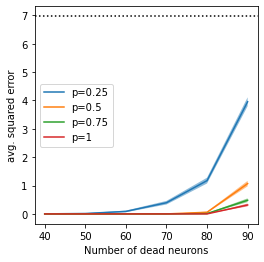

In [43]:
plt.figure(figsize=(4,4))

x = np.arange(4,10)*10
y = np.mean(errors,2)[4:10]
sem = stat.sem(errors,2)[4:10]
for ip in range(4):
    plt.plot(x,y[:,ip])
    plt.fill_between(x,y[:,ip]-sem[:,ip],y[:,ip]+sem[:,ip],alpha=0.5)

plt.legend(['p='+str(i) for i in [0.25,0.5,0.75,1]])
plt.xlabel('Number of dead neurons')
plt.ylabel('avg. squared error')
plt.axhline(y=np.var((lorenz - np.mean(lorenz,0))**2),ls='dotted',color='k')

## Supplementary Figure 3

Representation of the Kronecker product of the input.

The Input $\hat x$ is given by a network which represents the Lorenz system. 

The second network, using eq. (23) of the main text, outputs a signal $\approx \hat x \otimes \hat x$

In [20]:
# total time
Nt=100000

# neurons
N = 100 

# dimensionality of input
K = 3

# initialize (full) decoding matrix
D=np.random.randn(K,N) # N x K
D = D / np.sqrt(np.diag(D.T@D)) # normalize
D = D/10

# threshold
T = np.diag(D.T@D)/2

In [21]:
# Simulation of real solution
x0 = np.array([-11.40057002, -14.01987468,  27.49928125])
t = np.arange(0.0, 10, dt)
dt = 0.0001 #
lorenz = odeint(f, x0, t)
x = lorenz.T
Dx = np.gradient(x,axis=1)/dt

# Representation of real solution - this is fed as input to second network
x = lorenz.T
Dx = np.gradient(x,axis=1)/dt

# Voltage, spikes, rate
V = np.zeros([N,Nt+1])
s = np.zeros([N,Nt+1])
r = np.zeros([N,Nt+1])
r[:,0] = np.array(np.linalg.pinv(D)@x0) # pseudo-inverse
V[:,0] = 0.9*T
tau=1

for t in range(Nt):
    V[:,t+1] = V[:,t] + dt*(-V[:,t] + D.T@(x[:,t]+Dx[:,t]) - D.T@D@s[:,t])
    above = np.where(V[:,t+1] > T)[0]
    # introduce a control to let only one neuron fire
    if len(above):
        s[np.random.choice(above),t+1] = 1/dt
    r[:,t+1] = r[:,t] + dt*(s[:,t+1] - r[:,t])

In [22]:
# decode activity
x_ = D@r

In [23]:
# need a network that represents X (x) X
# need to do it as well as possible!!

Np = 200 # neurons
# dimensionality
Kp = K**2

# kernel
np.random.seed(42)
Dp=np.random.randn(Kp,Np) # N x K
Dp = Dp / np.sqrt(np.diag(Dp.T@Dp))
Dp = Dp * 4
# threshold
Tp = np.diag(Dp.T@Dp)/2
# tau
taup=5

# Voltage, spikes, rate
Vp = np.zeros([Np,Nt+1])
sp = np.zeros([Np,Nt+1])
rp = np.zeros([Np,Nt+1])
rp[:,0] = np.array(np.linalg.pinv(Dp)@np.kron(x0,x0)) # pseudo-inverse
Vp[:,0] = 0.9*Tp

# connections
O_f = -Dp.T @ Dp
O_x = Dp.T@np.kron(D,D)

In [24]:
for t in range(Nt):
    Vp[:,t+1] = Vp[:,t] + dt*(-taup*Vp[:,t]
                              + O_f @ sp[:,t]
                              + O_x @ (np.kron(r[:,t],s[:,t+1])
                                      +np.kron(s[:,t+1],r[:,t])
                                      +np.kron(r[:,t],r[:,t])*(taup-2*tau)))
    above = np.where(Vp[:,t+1] > Tp)[0]
    # introduce a control to let only one neuron fire
    if len(above):
        sp[np.argmax(Vp[:,t+1]),t+1] = 1/dt
    rp[:,t+1] = rp[:,t] + dt*(sp[:,t+1] - taup*rp[:,t])

In [37]:
# decode activity
xp = Dp@rp

In [28]:
# real squared
xq = np.zeros([K**2,Nt+1])
for t in range(Nt):
    xq[:,t] = np.kron(x[:,t],x[:,t])

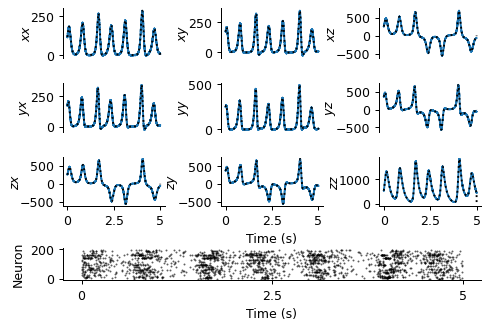

In [39]:
plt.figure(figsize=(6,4))
# labels
labs2=sum([[l2+l1 for l1 in labs] for l2 in labs],[])
# plot all 9 possible multiplications of the signlas: xx, xy, ..., zy, zz
# plot the final part to show that it doesn't lose precision at the end
for i in range(9):
    ax = plt.subplot(4,3,i+1)
    [ax.spines[s].set_visible(False) for s in ['right','top','bottom']]
    plt.plot(xp[i,50000:])
    plt.plot(xq[i,50000:],'k',ls='dotted')
    plt.ylabel('$'+labs2[i]+'$',labelpad=-2)
    plt.xticks([])
    if i>5:
        ax.spines['bottom'].set_visible(True)
        plt.xticks([0,25000, 50000],[0,2.5,5])
    if i == 7:
        plt.xlabel('Time (s)')

# plot the raster plot
# as above, plot the final part to show that it doesn't lose precision at the end
ax = plt.subplot(6,1,6)
[ax.spines[s].set_visible(False) for s in ['right','top']]
a=np.where(sp[:,50000:][:,(np.arange(int((len(s[0])-50000)/10))*10).astype(int)])
plt.scatter(a[1],a[0],marker='.',s=1,color='k',alpha=0.7,rasterized=True)
plt.xticks([0,2500, 5000],[0,2.5,5])
plt.xlabel('Time (s)')
plt.ylabel('Neuron')
plt.subplots_adjust(wspace=0.55,hspace=0.5)